In [1]:
import numpy as np
import pandas as pd
import os
import re
import warnings
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [2]:
os.getcwd()

'C:\\Users\\keato\\Documents\\LocalRStudio\\LJ_Leading_Indicators'

In [6]:
from thon.churn_functions import modernize, bake, simple_split
from thon.models.lasso import lasso_vars
# data = choose_features("data/out/features.csv", alpha_range = (0, 10), scale=False, save = False)

In [7]:
features = lasso_vars(scoring='r2',
                      split=(100, 120))

In [6]:
data = pd.read_csv("data/out/features.csv")

In [8]:
list(features)

['altsales_lag3',
 'AN_lag12',
 'cbpy30_lag3',
 'fedsurplus_lag3',
 'GT_lag3',
 'industry_lag9',
 'kwhcost_lag3',
 'manufinv_lag12',
 'month',
 'new_units_lag6',
 'retail_lag12',
 'tmaturity_lag12']

 Need to save slice

In [13]:
# Training data
X, y = data[list(features)], data['n']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .10, shuffle = False)
X_train, X_test, y_train, y_test = simple_split(X, y, 120)

In [20]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])

search = GridSearchCV(pipeline,
                  {'model__alpha':np.arange(2, 20, 1)}, # at least 2
                  cv = 5,
                  scoring = 'r2') # no stdout

search.fit(X_train, y_train)

coef = search.best_estimator_[1].coef_

out = X_train.iloc[:, coef != 0]

print("Alpha estimate:", search.best_params_)

Alpha estimate: {'model__alpha': 2}


In [21]:
# trtim X_test
X_test = X_test[out.columns]

In [74]:
len(out.columns)

9

In [22]:
# Train with selected features
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), 
                      LinearRegression())

# Train the model
model.fit(out, y_train)

# Store the fitted values as a time series with the same time index as
# the training data
train_pred = pd.Series(model.predict(out), index=out.index)
test_pred = pd.Series(model.predict(X_test), index =X_test.index)

In [94]:
# # Define the pipeline
# pipe = make_pipeline(StandardScaler(), Lasso())

# # Define the feature selector using Lasso regularization
# selector = SelectFromModel(estimator=Lasso())

# # Define the parameter grid to search over
# param_grid = {'lasso__alpha': range(1,  10, 0.1)}

# # Define the cross-validation scheme
# tscv = TimeSeriesSplit(n_splits=2)

# # Define the grid search object
# grid = GridSearchCV(pipe, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')

# # Fit the grid search object to the data
# grid.fit(X, y)

# # Get the best estimator and best number of features
# best_estimator = grid.best_estimator_
# # best_n_features = np.sum(best_estimator.named_steps['lasso'].get_support())

# # Print the best estimator and best number of features
# print("Best estimator:\n", best_estimator)
# # print("Best number of features:", best_n_features)

In [23]:
train_pred = train_pred.sort_index()
y_train = y_train.sort_index()
test_pred = test_pred.sort_index()
y_test = y_test.sort_index()

Predictions

1112.3293099394473
9.26941091616206


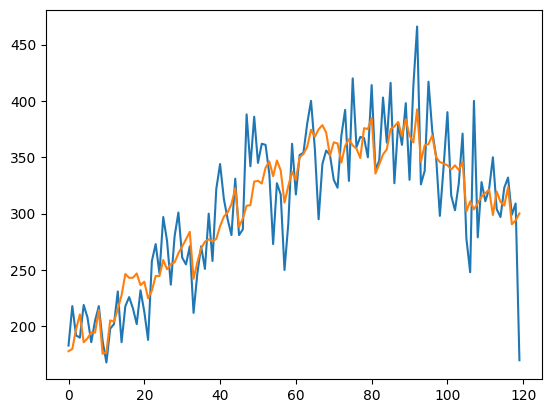

In [77]:
plot_eval(train_pred, y_train)

5455.244890861965
181.8414963620655


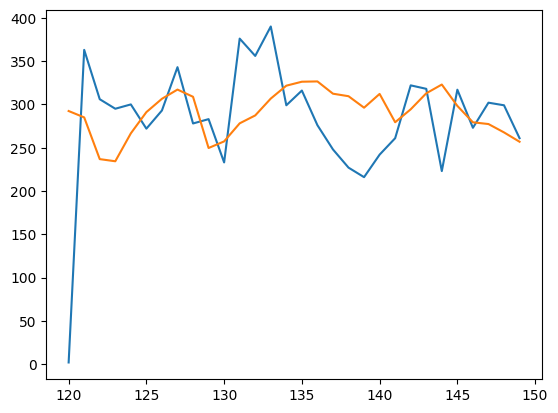

In [24]:
plot_eval(test_pred, y_test)
# why does it look like this???

In [25]:
from pandas.plotting import lag_plot, autocorrelation_plot

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

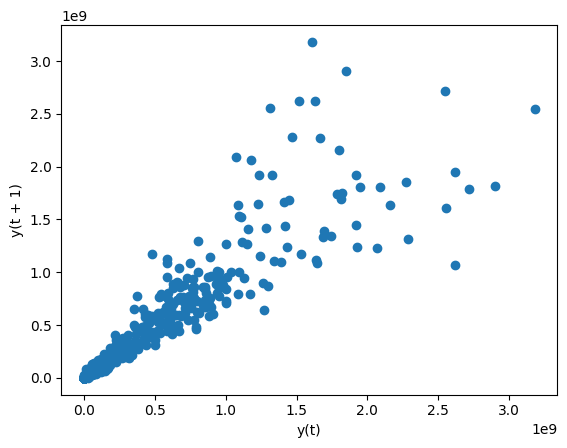

In [26]:
lag_plot(data, 1)

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

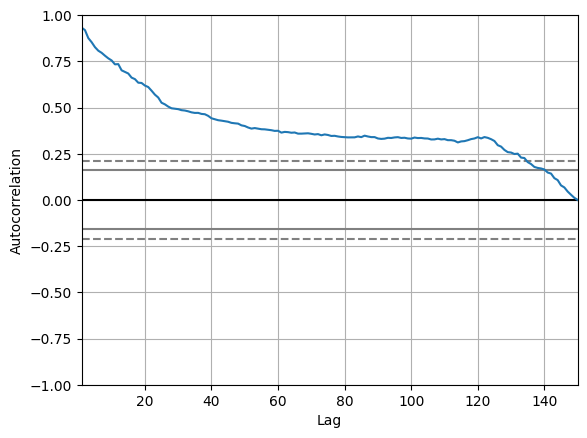

In [27]:
autocorrelation_plot(data)

In [24]:
cdf = pd.DataFrame(model.steps[1][1].coef_, out.columns, columns=['importance'])
cdf

,importance
altsales_lag3,8.797612
AN_lag12,5.797564
cbpy30_lag3,-8.921059
fedsurplus_lag3,4.045913
GT_lag3,31.013085
industry_lag9,8.749175
month,9.329348
tmaturity_lag12,-2.100641


In [15]:
def mymodernize(feature_list, complete_path = "./data/out/complete.csv", supp_path = "./data/out/supp_ext.csv", ahead = 3):
    
    complete = pd.read_csv(complete_path)
    
    supp = pd.read_csv(supp_path)
    
    slist = []
    
    for f in feature_list:
            
        # get seasonal cols first
        if f in list(supp.columns):
            
            x = supp[f]
            
        elif f in list(complete.columns):
        
            x = complete[f.split("_lag")[0] + "_lag" + str(pd.to_numeric(re.sub(r".*_lag", "", f)) - ahead)].tail(ahead)
            
            x.name = f
            
            x = x.reset_index(drop = True)
              
        else:
            
            print("{} not found".format(f))
            break
            
        slist.append(x)
        
    return pd.concat(slist, axis = 1)

In [26]:
cdf.columns

Index(['importance'], dtype='object')

In [16]:
newdata = mymodernize(cdf.index)

NameError: name 'cdf' is not defined

In [10]:
from thon.models import linear
from thon.models import lasso

In [11]:
features = lasso.lasso_vars(scoring='r2',
                      split=120)

In [12]:
features

['altsales_lag3',
 'AN_lag12',
 'cbpy30_lag3',
 'GT_lag3',
 'industry_lag9',
 'kwhcost_lag3',
 'laborpart_lag3',
 'month',
 'newhouses_lag3']

In [9]:
linear.linear_model(feature_selection = features, split = 120)

NameError: name 'linear' is not defined

In [42]:
pred = model.predict(newdata)

In [43]:
# combine train, test, and pred into 1 df
full = bake(y_train, y_test, train_pred, test_pred, pred)

In [39]:
full.to_csv("data/out/linear.csv")

In [44]:
full

,pred,actual,group
0,183.000000,178.010504,train
1,218.000000,180.004135,train
2,192.000000,197.605886,train
3,190.000000,210.649893,train
4,219.000000,185.930821,train
...,...,...,...
148,299.000000,267.679875,test
149,261.000000,256.897864,test
150,264.072430,NaN,pred
151,289.374329,NaN,pred
